# ADS 509 Team 1 Final Project

## Tweets Classification on Cryptocurrencies

### University of San Diego - Applied Data Science

#### Chow, Eva
#### Duan, Dingyi 
#### Tan, Abby

### Load Necessary Libraries

In [1]:
# import some necessary libraries

!pip install psawimport datetime as dt
!pip install demoji
!pip install lexical_diversity
!pip install flask
import re
import nltk
import demoji
import random
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns
import nltk.classify
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix
from collections import Counter, defaultdict
from lexical_diversity import lex_div as ld
from matplotlib import pyplot as plt
from datetime import datetime as dt
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from string import punctuation
from sklearn import metrics

ERROR: Could not find a version that satisfies the requirement psawimport (from versions: none)
ERROR: No matching distribution found for psawimport


/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# prepare our crypto candidates
handles = ["Bitcoin", "ethereum", "Cardano", "dogecoin", "ShibainuCoin"]
tweets_data = dict()

### Pulling Request Using Tweepy

### Cleaning Tweet

In [3]:
# punctuation variations
punctuation = set(punctuation) # speeds up comparison

tw_punct = punctuation #- {"#"} # remove hashtags from punctuation list

# stopwords
sw = stopwords.words("english")
sw = [i.replace("'","") for i in sw]  # remove single quote from sw

# remove retweet word

sw.extend(['rt', 'retweet'])

# we don't really need the actual names of the cryptos especially
# when the hashtags are removed
sw.extend(['bitcoin', 'ethereum', 'cardano','dogecoin','shib','shiba'])



# some useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")



def descriptive_stats(tokens,handle) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens)
    num_characters = sum([len(token) for token in tokens])
    top5_tokens = Counter(tokens).most_common()[:5]
    
    print("For", handle, ": \n")
    print(f"There are {num_tokens} tokens in the data.")
    print(f"There are {num_unique_tokens} unique tokens in the data.")
    print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    print(f"There are {num_characters} characters in the data.")
    print(f"These are the five most common tokens in the data: {top5_tokens}.")

    return "\n\n"

# text cleaning functions
def remove_url(s): 
    return re.sub(r'http\S+', '', s)

def lower_case(text):
    return text.casefold()
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return text.split()

def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [i for i in tokens if not i in sw]
    return tokens

def remove_emoji(tokens) :
    dem = demoji.findall(tokens)
    for item in dem.keys():
        tokens = tokens.replace(item, ' ')
    return tokens

# pipeline implementation
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return tokens


### Tokenization and Normalization

**Cleaning steps** 

* remove urls
* Casefold to lowercase
* Remove punctuation other than hashtags
* Split on whitespace
* Remove stopwords
* Remove emoji

In [4]:
# REMOVE FOR EVERYONE ELSE LATER
import os

bitcoin = pd.read_csv(os.getcwd() + '/twitter/' + 'Bitcoin_tweets.txt', sep='\t')
ethereum = pd.read_csv(os.getcwd() + '/twitter/' + 'ethereum_tweets.txt', sep='\t')
cardano = pd.read_csv(os.getcwd() + '/twitter/' + 'Cardano_tweets.txt', sep='\t')
dogecoin = pd.read_csv(os.getcwd() + '/twitter/' + 'dogecoin_tweets.txt', sep='\t')
shibainucoin = pd.read_csv(os.getcwd() + '/twitter/' + 'ShibainuCoin_tweets.txt', sep='\t')

In [5]:
bitcoin.columns = ['tweets']
ethereum.columns = ['tweets']
cardano.columns = ['tweets']
dogecoin.columns = ['tweets']
shibainucoin.columns = ['tweets']

In [6]:
bitcoin['crypto_type'] = 'Bitcoin'
ethereum['crypto_type'] = 'ethereum'
cardano['crypto_type'] = 'Cardano'
dogecoin['crypto_type'] = 'dogecoin'
shibainucoin['crypto_type'] = 'ShibainuCoin'

In [7]:
tweets_df = pd.concat([bitcoin, ethereum, cardano, dogecoin, shibainucoin]).reset_index(drop=True)

In [8]:
tweets_df.head()

,tweets,crypto_type
0,https://t.co/9xJWYwypPM,Bitcoin
1,A whopping $14m of short liquidations. https:/...,Bitcoin
2,https://t.co/2hsh3GpR8L,Bitcoin
3,While political currencies evaporate; this is ...,Bitcoin
4,Poof. https://t.co/CdN0PV2lWb,Bitcoin


In [9]:
tweets_df

,tweets,crypto_type
0,https://t.co/9xJWYwypPM,Bitcoin
1,A whopping $14m of short liquidations. https:/...,Bitcoin
2,https://t.co/2hsh3GpR8L,Bitcoin
3,While political currencies evaporate; this is ...,Bitcoin
4,Poof. https://t.co/CdN0PV2lWb,Bitcoin
...,...,...
5016,$SHIB\nLet's build the strongest🐶community in ...,ShibainuCoin
5017,We are in #Coingecko \n\nhttps://t.co/E8YIc9cVu8,ShibainuCoin
5018,@TheMoonCarl $SHIB,ShibainuCoin
5019,Join the SHIB ARMY on Telegram\n\nhttps://t.co...,ShibainuCoin


In [10]:
crypto_pipeline1 = [remove_url, lower_case, remove_punctuation, tokenize, remove_stop]
# crypto_pipeline = [remove_url, lower_case, remove_punctuation, tokenize, remove_stop]
tweets_df["tokens"] = tweets_df["tweets"].apply(prepare,pipeline=crypto_pipeline1)
tweets_df["num_tokens"] = tweets_df["tokens"].map(len) 

In [11]:
tweets_df

,tweets,crypto_type,tokens,num_tokens
0,https://t.co/9xJWYwypPM,Bitcoin,[],0
1,A whopping $14m of short liquidations. https:/...,Bitcoin,"[whopping, 14m, short, liquidations]",4
2,https://t.co/2hsh3GpR8L,Bitcoin,[],0
3,While political currencies evaporate; this is ...,Bitcoin,"[political, currencies, evaporate, sound, mone...",7
4,Poof. https://t.co/CdN0PV2lWb,Bitcoin,[poof],1
...,...,...,...,...
5016,$SHIB\nLet's build the strongest🐶community in ...,ShibainuCoin,"[lets, build, strongest🐶community, tweeter, hi...",8
5017,We are in #Coingecko \n\nhttps://t.co/E8YIc9cVu8,ShibainuCoin,[coingecko],1
5018,@TheMoonCarl $SHIB,ShibainuCoin,[themooncarl],1
5019,Join the SHIB ARMY on Telegram\n\nhttps://t.co...,ShibainuCoin,"[join, army, telegram]",3


### Calculate Descriptive Statistics On the Cryptos Tokens.

In [12]:
for handle in handles:
    token_sum = []
    start_index = tweets_df['crypto_type'].ne(handle).idxmin()
    end_index = len(tweets_df.loc[tweets_df['crypto_type'] == handle])
    for i in range(start_index, start_index+end_index):
        token_row = tweets_df['tokens'].loc[tweets_df['crypto_type'] == handle][i] 
        token_sum = token_sum + token_row # use + to stitch all list together
    print(descriptive_stats(token_sum, handle))

For Bitcoin : 

There are 10177 tokens in the data.
There are 4410 unique tokens in the data.
The lexical diversity is 0.433 in the data.
There are 62205 characters in the data.
These are the five most common tokens in the data: [('btc', 72), ('price', 59), ('inflation', 46), ('market', 45), ('2021', 44)].



For ethereum : 

There are 13663 tokens in the data.
There are 4477 unique tokens in the data.
The lexical diversity is 0.328 in the data.
There are 84396 characters in the data.
These are the five most common tokens in the data: [('latest', 150), ('new', 148), ('eth2', 144), ('week', 118), ('news', 104)].



For Cardano : 

There are 14319 tokens in the data.
There are 4404 unique tokens in the data.
The lexical diversity is 0.308 in the data.
There are 99227 characters in the data.
These are the five most common tokens in the data: [('cardanostiftung', 273), ('cardanocommunity', 252), ('blockchain', 182), ('join', 132), ('amp', 131)].



For dogecoin : 

There are 9519 tokens in

### Build Word Clouds For All The Cryptos. 

In [13]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if sw is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in sw}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

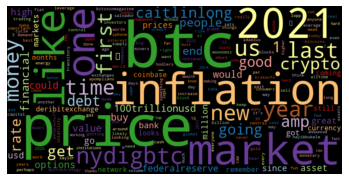

In [14]:
wc1 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'Bitcoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc1['freq'], title=None, max_words=200, stopwords=None)

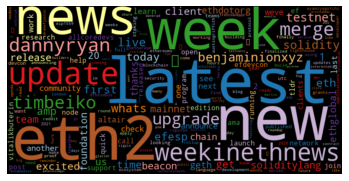

In [15]:
wc2 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'ethereum'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc2['freq'], title=None, max_words=200, stopwords=None)

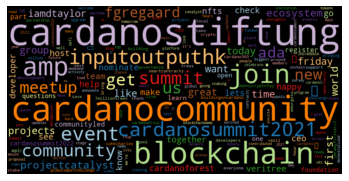

In [16]:
wc3 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'Cardano'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc3['freq'], title=None, max_words=200, stopwords=None)

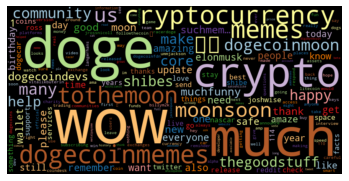

In [17]:
wc4 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'dogecoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc4['freq'], title=None, max_words=200, stopwords=None)

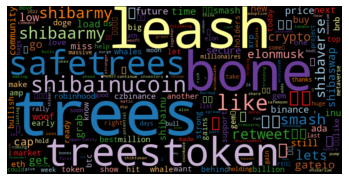

In [18]:
wc5 = count_words(tweets_df.loc[tweets_df['crypto_type'] == 'ShibainuCoin'], column='tokens', preprocess=None, min_freq=2)
wordcloud(wc5['freq'], title=None, max_words=200, stopwords=None)

### Classification Models

In [19]:
all_tokens = []
for i in tweets_df['tokens']:
    all_tokens += i

# look at some random sampling tokens
print(random.sample(all_tokens, 20))

['stake', 'cardanostiftung', 'dannyryan', 'may', 'now🌳', 'focused', 'un', 'epoch', 'tfw', 'show', '6', 'expect', 'counterfeited', 'learn', 'redemption', 'freedom', 'present', '🇪🇸', 'thumbs', 'thanks']


In [20]:
word_cutoff = 5
word_dist = nltk.FreqDist(all_tokens)
feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model (including emojis).")

With a word cutoff of 5, we have 1884 as features in the model (including emojis).


In [21]:
# look at some random sampling feature words
print(random.sample(feature_words, 20))

['announce', 'crypto', 'de', 'updated', '⚡️', '100', 'right', 'huge', 'might', 'nmkrio', 'company', 'protolambda', 'care', 'champmedici', 'reserve', 'send', 'institutions', 'least', 'act', 'alltime']


In [22]:
def conv_features(text,fw) :
    
    ret_word = [i for i in text]
    ret_bool = [True if i in fw else False for i in text]
    
    ret_dict = dict(zip(ret_word,ret_bool))
    
    return(ret_dict)

In [23]:
convention_data = [[tweets_df['tokens'][i], tweets_df['crypto_type'][i]] for i in range(len(tweets_df))]

In [24]:
featuresets = [(conv_features(tokens,feature_words), crypto) for (tokens, crypto) in convention_data]

Each of the tweet contains a feature set, let's print some feature sets

In [25]:
print(featuresets[:3])

[({}, 'Bitcoin'), ({'whopping': True, '14m': False, 'short': True, 'liquidations': False}, 'Bitcoin'), ({}, 'Bitcoin')]


In [26]:
random.seed(1314)
random.shuffle(featuresets)

# choose train:test = 7:3 
test_size = round(len(featuresets)*(3/10))
test_size

1506

#### Naive Bayes
##### 1. With emoji

In [27]:
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print('The training set accuracy for Naive Bayes model with emojis is:',round(nltk.classify.accuracy(classifier, train_set),3))

The training set accuracy for Naive Bayes model with emojis is: 0.95


Let's look at the top 25 most informative features/tokens of our model

In [28]:
classifier.show_most_informative_features(25)

Most Informative Features
                   trees = True           Shibai : dogeco =    207.5 : 1.0
                      ❤️ = True           Shibai : ethere =    188.1 : 1.0
                       💎 = True           Shibai : ethere =    182.4 : 1.0
                       🌳 = True           Shibai : ethere =    147.9 : 1.0
                       🔥 = True           Shibai : Bitcoi =    111.9 : 1.0
                     wow = True           dogeco : ethere =    108.5 : 1.0
                    doge = True           dogeco : ethere =     95.1 : 1.0
         cardanostiftung = True           Cardan : Shibai =     85.0 : 1.0
        cardanocommunity = True           Cardan : Shibai =     83.5 : 1.0
                     low = True           Shibai : Cardan =     61.6 : 1.0
                       🚀 = True           Shibai : dogeco =     54.6 : 1.0
                    grab = True           Shibai : Cardan =     45.2 : 1.0
                   event = True           Cardan : dogeco =     42.9 : 1.0

For the 25 most informative features, 6 of them are emojis and top5 features have 3 emojis!

All of them emoji features are pointing out that for Shiba Inu's tweets are symbolic for its use of emojis.

Let's run some prediction on the test set

In [29]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto = classifier.classify(conv_features(tokens,feature_words))
    
    results[crypto][estimated_crypto] += 1


In [30]:
results

defaultdict(<function __main__.<lambda>()>,
            {'dogecoin': defaultdict(int,
                         {'ShibainuCoin': 34,
                          'dogecoin': 219,
                          'ethereum': 21,
                          'Bitcoin': 8,
                          'Cardano': 11}),
             'Bitcoin': defaultdict(int,
                         {'dogecoin': 13,
                          'ethereum': 56,
                          'Bitcoin': 196,
                          'ShibainuCoin': 46,
                          'Cardano': 18}),
             'ethereum': defaultdict(int,
                         {'ethereum': 282,
                          'ShibainuCoin': 12,
                          'Cardano': 16,
                          'dogecoin': 3,
                          'Bitcoin': 1}),
             'Cardano': defaultdict(int,
                         {'Cardano': 323,
                          'ShibainuCoin': 9,
                          'ethereum': 8,
                    

Let's look at some confusion matrix for better visual

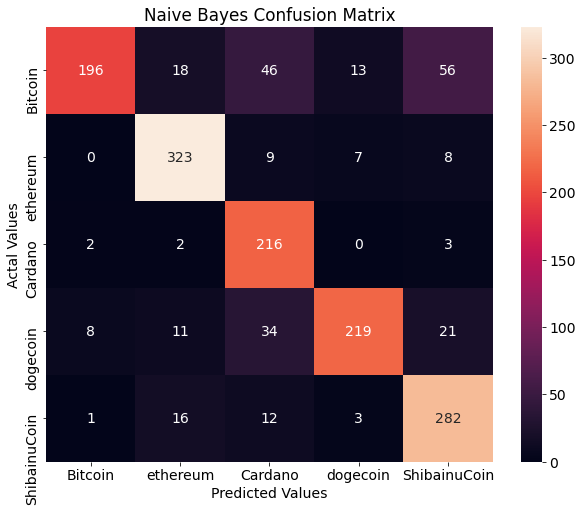



The test set accuracy of Naive Bayes model with emojis: 0.821


In [31]:
actual = [test_set[i][1] for i in range(len(test_set))]
predicted = [classifier.classify(conv_features(test_set[i][0],feature_words)) for i in range(len(test_set))] 

cm = confusion_matrix(actual, predicted)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True,fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy
print('\n')
print("The test set accuracy of Naive Bayes model with emojis:", round(compute_accuracy(actual, predicted),3))

Accuracy of 0.959 for training and 0.829 for test is very good for our model performance.

We suspect that the emojis are playing a significant role in the model performance as they can be unique to certain type of coins.

We will now remove the emojis and see if our hypothesis is correct.

##### 2. Without emoji

In [32]:
# a different pipeline including remove_emoji 
crypto_pipeline2 = [remove_url, lower_case, remove_punctuation, remove_emoji, tokenize, remove_stop]

# add a new column for tokens without emojis
tweets_df["tokens_no_emoji"] = tweets_df["tweets"].apply(prepare,pipeline=crypto_pipeline2)

In [33]:
all_tokens_no_emoji = []
for i in tweets_df['tokens_no_emoji']:
    all_tokens_no_emoji += i

# look at some random sampling tokens
print(random.sample(all_tokens_no_emoji, 20))

['nft', 'bond', 'sustainability', 'bearer', 'analysis', 'week', 'find', 'debut', 'getting', 'hardware', 'look', 'today', 'leads', 'shibainucoin', 'inu', 'shadow', 'around', 'leash', 'far', 'accepts']


In [34]:
word_cutoff = 5
word_dist = nltk.FreqDist(all_tokens_no_emoji)
feature_words_no_emoji = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words_no_emoji.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words_no_emoji)} as features in the model (without emojis).")

With a word cutoff of 5, we have 1793 as features in the model (without emojis).


Compared to 1812 features with emojis included, we removed 89 emojis from the feature sets

In [35]:
convention_data_no_emoji = [[tweets_df['tokens_no_emoji'][i], tweets_df['crypto_type'][i]] for i in range(len(tweets_df))]
featuresets_no_emoji = [(conv_features(tokens,feature_words_no_emoji), crypto) for (tokens, crypto) in convention_data_no_emoji]

In [36]:
random.seed(1314)
random.shuffle(featuresets)

# choose train:test = 7:3 
test_size_no_emoji = round(len(featuresets_no_emoji)*(3/10))
test_size_no_emoji

1506

In [37]:
test_set_no_emoji, train_set_no_emoji = featuresets_no_emoji[:test_size_no_emoji], featuresets_no_emoji[test_size_no_emoji:]
classifier_no_emoji = nltk.NaiveBayesClassifier.train(train_set_no_emoji)
print('The training set accuracy for Naive Bayes model without emojis is:"',round(nltk.classify.accuracy(classifier_no_emoji, train_set),3))

The training set accuracy for Naive Bayes model without emojis is:" 0.759


In [38]:
classifier_no_emoji.show_most_informative_features(25)

Most Informative Features
                   trees = True           Shibai : ethere =    212.3 : 1.0
        cardanocommunity = True           Cardan : Shibai =    119.7 : 1.0
                    doge = True           dogeco : ethere =     84.6 : 1.0
                     low = True           Shibai : Cardan =     80.2 : 1.0
         cardanostiftung = True           Cardan : Shibai =     76.3 : 1.0
                     cap = True           Shibai : dogeco =     69.2 : 1.0
                     wow = True           dogeco : Shibai =     66.2 : 1.0
                    grab = True           Shibai : Cardan =     63.1 : 1.0
                   price = True           Shibai : Cardan =     62.1 : 1.0
                  secure = True           Shibai : dogeco =     51.8 : 1.0
                    load = True           Shibai : dogeco =     49.3 : 1.0
                  latest = True           ethere : dogeco =     47.8 : 1.0
                    like = True           Shibai : ethere =     42.6 : 1.0

In [39]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto_no_emoji = classifier_no_emoji.classify(conv_features(tokens,feature_words_no_emoji))
    
    results[crypto][estimated_crypto_no_emoji] += 1


In [40]:
results

defaultdict(<function __main__.<lambda>()>,
            {'ShibainuCoin': defaultdict(int,
                         {'Cardano': 1, 'ShibainuCoin': 220, 'dogecoin': 2}),
             'Cardano': defaultdict(int,
                         {'Cardano': 341,
                          'ethereum': 1,
                          'ShibainuCoin': 3,
                          'dogecoin': 2}),
             'Bitcoin': defaultdict(int,
                         {'ShibainuCoin': 136,
                          'Cardano': 117,
                          'ethereum': 33,
                          'dogecoin': 43}),
             'ethereum': defaultdict(int,
                         {'ethereum': 297,
                          'Cardano': 12,
                          'ShibainuCoin': 3,
                          'dogecoin': 2}),
             'dogecoin': defaultdict(int,
                         {'dogecoin': 273,
                          'ethereum': 4,
                          'ShibainuCoin': 8,
                   

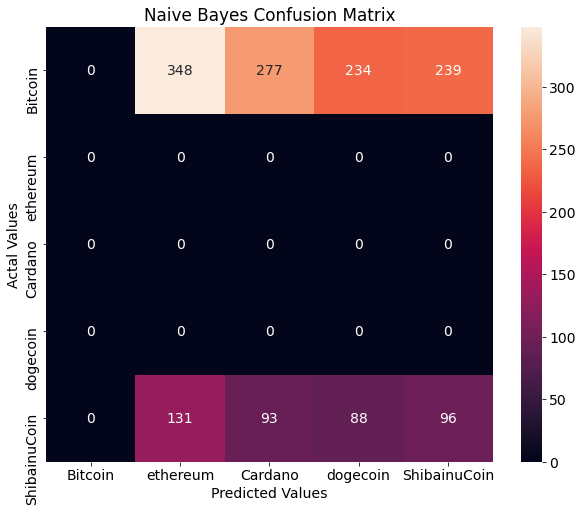



The test set accuracy of Naive Bayes model without emojis: 0.064


In [41]:
actual_no_emoji = [test_set_no_emoji[i][1] for i in range(len(test_set_no_emoji))]
predicted_no_emoji = [classifier_no_emoji.classify(conv_features(test_set[i][0],feature_words_no_emoji)) for i in range(len(test_set_no_emoji))] 

cm_no_emoji = confusion_matrix(actual_no_emoji, predicted_no_emoji)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_no_emoji = pd.DataFrame(cm_no_emoji, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_df_no_emoji, annot=True,fmt='g')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print('\n')
print("The test set accuracy of Naive Bayes model without emojis:", round(compute_accuracy(actual_no_emoji, predicted_no_emoji),3))

WOW! With an accuracy score on training set of 0.767 and less than 0.1 on test set of mere 0.072, our model could barely recognize anything cryptocurrency using words alone without any emojis!

This results confirms that our hypothesis is proven to be correct and it is a learnt fact that emojis are indeed a key factor for classifying different cryptocurrencies.

#### SVM

In [42]:
classifier_svm = nltk.classify.SklearnClassifier(LinearSVC())
classifier_svm.train(train_set)
print('The training set accuracy for SVM model is:',round(nltk.classify.accuracy(classifier_svm, train_set),3))

The training set accuracy for SVM model is: 0.982


In [43]:
cryptos = handles
results = defaultdict(lambda: defaultdict(int))

random.shuffle(test_set)

for idx, tp in enumerate(test_set) :
    tokens, crypto = tp    
    # Now do the same thing as above, but we store the results rather
    # than printing them. 
   
    # get the estimated party
    estimated_crypto = classifier_svm.classify(conv_features(tokens,feature_words))
    
    results[crypto][estimated_crypto] += 1

In [44]:
results

defaultdict(<function __main__.<lambda>()>,
            {'ethereum': defaultdict(int,
                         {'ethereum': 263,
                          'Bitcoin': 30,
                          'dogecoin': 11,
                          'Cardano': 9,
                          'ShibainuCoin': 1}),
             'dogecoin': defaultdict(int,
                         {'dogecoin': 213,
                          'ShibainuCoin': 3,
                          'Bitcoin': 53,
                          'Cardano': 8,
                          'ethereum': 16}),
             'Bitcoin': defaultdict(int,
                         {'Bitcoin': 281,
                          'ethereum': 11,
                          'dogecoin': 32,
                          'ShibainuCoin': 3,
                          'Cardano': 2}),
             'ShibainuCoin': defaultdict(int,
                         {'ShibainuCoin': 198,
                          'Bitcoin': 16,
                          'dogecoin': 6,
                 

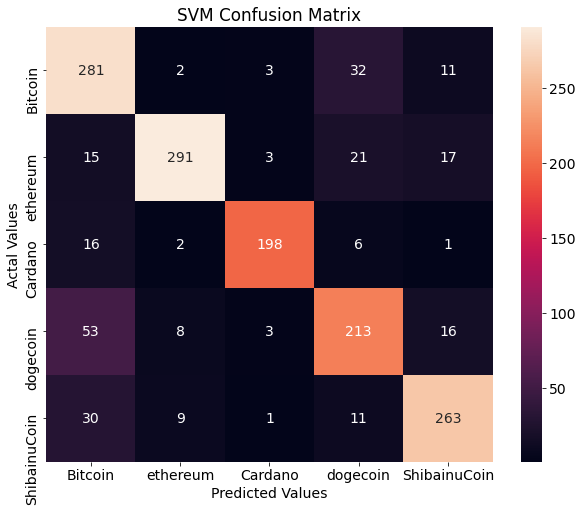



The test set accuracy of SVM model is: 0.827


In [45]:
actual_svm = [test_set[i][1] for i in range(len(test_set))]
predicted_svm = [classifier_svm.classify(conv_features(test_set[i][0],feature_words)) for i in range(len(test_set))] 

cm_svm = confusion_matrix(actual_svm, predicted_svm)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_svm_df = pd.DataFrame(cm_svm, index = handles, columns = handles)

#Plotting the confusion matrix
font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.figure(figsize=(10,8))
sns.heatmap(cm_svm_df, annot=True,fmt='g')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print('\n')
print("The test set accuracy of SVM model is:", round(compute_accuracy(actual_svm, predicted_svm),3))

In [46]:
class_compare = pd.DataFrame({
                            'Models': ['Naive Bayes', 'SVM'],
                            'Training Accuracy': [round(nltk.classify.accuracy(classifier, train_set),3), round(nltk.classify.accuracy(classifier_svm, train_set),3)],
                            'Test Accuracy': [round(compute_accuracy(actual, predicted),3), round(compute_accuracy(actual_svm, predicted_svm),3)]
                             })
class_compare

,Models,Training Accuracy,Test Accuracy
0,Naive Bayes,0.950,0.821
1,SVM,0.982,0.827


Both models have been performing with acceptable result and SVM outperforms Naive Bayes slightly with 0.981 of training accuracy and 0.853 test accuracy.

### Topic Modeling

In [47]:
tweets_df.head()

,tweets,crypto_type,tokens,num_tokens,tokens_no_emoji
0,https://t.co/9xJWYwypPM,Bitcoin,[],0,[]
1,A whopping $14m of short liquidations. https:/...,Bitcoin,"[whopping, 14m, short, liquidations]",4,"[whopping, 14m, short, liquidations]"
2,https://t.co/2hsh3GpR8L,Bitcoin,[],0,[]
3,While political currencies evaporate; this is ...,Bitcoin,"[political, currencies, evaporate, sound, mone...",7,"[political, currencies, evaporate, sound, mone..."
4,Poof. https://t.co/CdN0PV2lWb,Bitcoin,[poof],1,[poof]


In [48]:
# Let's add some helpful columns on the df
tweets_df['char_len'] = tweets_df['tweets'].apply(len)
tweets_df['word_len'] = tweets_df['tweets'].apply(lambda x: len(x.split()))
tweets_df.head()

,tweets,crypto_type,tokens,num_tokens,tokens_no_emoji,char_len,word_len
0,https://t.co/9xJWYwypPM,Bitcoin,[],0,[],23,1
1,A whopping $14m of short liquidations. https:/...,Bitcoin,"[whopping, 14m, short, liquidations]",4,"[whopping, 14m, short, liquidations]",62,7
2,https://t.co/2hsh3GpR8L,Bitcoin,[],0,[],23,1
3,While political currencies evaporate; this is ...,Bitcoin,"[political, currencies, evaporate, sound, mone...",7,"[political, currencies, evaporate, sound, mone...",98,12
4,Poof. https://t.co/CdN0PV2lWb,Bitcoin,[poof],1,[poof],29,2


<AxesSubplot:title={'center':'Average Tweet Length Comparison'}, xlabel='crypto_type', ylabel='Counts'>

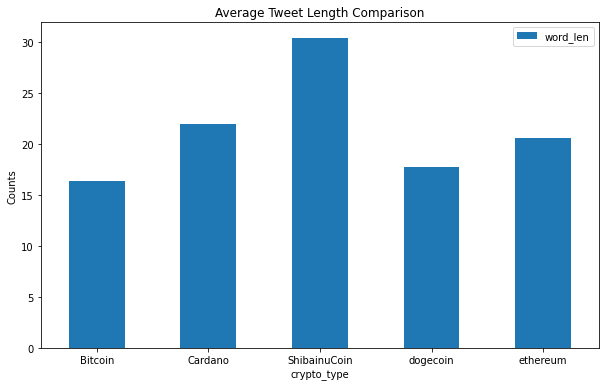

In [49]:
%matplotlib inline
# checking to see which crypto has the most words
tweets_df.groupby('crypto_type').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6), rot = 0,ylabel = 'Counts',title = 'Average Tweet Length Comparison')

Shiba Inu has the longest average tweet length while Bitcoin has surprisingly the shortest!

#### Count and TF-IDF vectorizations.

In [50]:
# using a cutoff of minimum of 5 words and 70% as maximum.
count_tweet_vectorizer = CountVectorizer(stop_words=sw, min_df=5, max_df=0.7)
count_tweet_vectors = count_tweet_vectorizer.fit_transform(tweets_df["tweets"])
count_tweet_vectors.shape

(5021, 2051)

In [51]:
pd.DataFrame(count_tweet_vectors.todense())

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
tfidf_tweet_vectorizer = TfidfVectorizer(stop_words=sw, min_df=5, max_df=0.7)
tfidf_tweet_vectors = tfidf_tweet_vectorizer.fit_transform(tweets_df['tweets'])
tfidf_tweet_vectors.shape

(5021, 2051)

In [53]:
pd.DataFrame(tfidf_tweet_vectors.todense())

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The `count_tweet_vectors` holds the absolute counts for each word in different corpura while
the TfidfTransformer (`tfidf_tweet_vectors`) transforms this count matrix to a 
normalized tf or tf-idf representation in float format (percentage).

The two topic-document matrice can help understand the dimensionality of the keywords and documents.

#### Display Topics Function

In [54]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

#### Non-Negative Matrix Factorization

In [55]:
nmf_tweet_model = NMF(n_components=5, random_state=314)
W_tweet_matrix = nmf_tweet_model.fit_transform(tfidf_tweet_vectors)
H_tweet_matrix = nmf_tweet_model.components_

In [56]:
display_topics(nmf_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 https (25.91)
 co (24.97)
 go (0.45)
 doge (0.39)
 got (0.38)

Topic 01
 trees (3.48)
 leash (3.07)
 bone (3.07)
 trees_token (3.01)
 safetrees (2.71)

Topic 02
 doge (7.71)
 wow (7.48)
 dogecoinmemes (7.16)
 memes (7.16)
 tothemoon (7.12)

Topic 03
 http (12.13)
 much (10.62)
 wow (8.79)
 co (4.09)
 many (1.38)

Topic 04
 cardanocommunity (2.27)
 event (1.59)
 cardanosummit2021 (1.59)
 join (1.50)
 cardanostiftung (1.40)


In [57]:
nmf_W_tweet_matrix = pd.DataFrame(W_tweet_matrix)
nmf_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
nmf_W_tweet_matrix['Topic'] = nmf_W_tweet_matrix.idxmax(axis=1)

In [58]:
nmf_topic = pd.concat([nmf_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )

In [59]:
nmf_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [60]:
nmf_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         710
          ethereum        330
          dogecoin        260
          Cardano         182
          ShibainuCoin     72
Topic 01  ShibainuCoin    660
          Bitcoin          78
          dogecoin         19
          Cardano          18
          ethereum         18
Topic 02  dogecoin        139
          Bitcoin          27
          ShibainuCoin     12
          Cardano           7
          ethereum          4
Topic 03  dogecoin        340
          Bitcoin          28
          ethereum         12
          Cardano           7
          ShibainuCoin      2
Topic 04  Cardano         882
          ethereum        736
          Bitcoin         255
          dogecoin        199
          ShibainuCoin     24
Name: crypto_type, dtype: int64

#### Latent Semantic Analysis

In [61]:
svd_tweet_model = TruncatedSVD(n_components=5, n_iter=7, random_state=314)
svd_W_tweet_matrix = svd_tweet_model.fit_transform(tfidf_tweet_vectors)
svd_H_tweet_matrix = svd_tweet_model.components_

In [62]:
display_topics(svd_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 https (11.50)
 co (11.33)
 trees (0.77)
 cardanocommunity (0.68)
 like (0.67)

Topic 01
 trees (3.18)
 leash (2.80)
 bone (2.80)
 trees_token (2.76)
 safetrees (2.47)

Topic 02
 wow (10.56)
 doge (6.03)
 http (4.91)
 much (4.85)
 crypto (4.83)

Topic 03
 http (8.27)
 much (6.75)
 wow (2.34)
 update (1.23)
 community (1.22)

Topic 04
 cardanocommunity (2.65)
 cardanosummit2021 (1.88)
 event (1.88)
 join (1.73)
 cardanostiftung (1.64)


In [63]:
svd_W_tweet_matrix = pd.DataFrame(svd_W_tweet_matrix)
svd_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
svd_W_tweet_matrix['Topic'] = svd_W_tweet_matrix.idxmax(axis=1)

In [64]:
svd_topic = pd.concat([svd_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )
svd_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [65]:
svd_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         744
          ethereum        412
          Cardano         364
          dogecoin        339
          ShibainuCoin    129
Topic 01  ShibainuCoin    625
          Bitcoin         129
          dogecoin         41
          Cardano          36
          ethereum         27
Topic 02  dogecoin        242
          Bitcoin          22
          Cardano          10
          ethereum          6
          ShibainuCoin      3
Topic 03  dogecoin        196
          Bitcoin          23
          ethereum         20
          Cardano           7
          ShibainuCoin      1
Topic 04  Cardano         679
          ethereum        635
          Bitcoin         180
          dogecoin        139
          ShibainuCoin     12
Name: crypto_type, dtype: int64

#### Latent Dirichlet Allocation

In [66]:
lda_tweet_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_W_tweet_matrix = lda_tweet_model.fit_transform(count_tweet_vectors)
lda_H_tweet_matrix = lda_tweet_model.components_

In [67]:
display_topics(lda_tweet_model, tfidf_tweet_vectorizer.get_feature_names())


Topic 00
 co (13.02)
 https (11.74)
 wow (1.62)
 http (1.47)
 much (1.34)

Topic 01
 trees (5.04)
 https (4.85)
 co (4.78)
 leash (3.45)
 bone (3.38)

Topic 02
 cardanostiftung (2.70)
 community (1.93)
 amp (1.43)
 blockchain (1.39)
 ecosystem (0.91)

Topic 03
 https (5.66)
 co (5.49)
 latest (1.75)
 week (1.59)
 eth2 (1.56)

Topic 04
 us (1.18)
 world (0.95)
 foundation (0.93)
 around (0.83)
 solidity (0.74)


In [68]:
lda_W_tweet_matrix = pd.DataFrame(lda_W_tweet_matrix)
lda_W_tweet_matrix.columns = ['Topic 00', 'Topic 01', 'Topic 02', 'Topic 03', 'Topic 04']
lda_W_tweet_matrix['Topic'] = lda_W_tweet_matrix.idxmax(axis=1)

In [69]:
lda_topic = pd.concat([lda_W_tweet_matrix[['Topic']], tweets_df[['crypto_type']]], axis=1 )
lda_topic.head(3)

,Topic,crypto_type
0,Topic 00,Bitcoin
1,Topic 00,Bitcoin
2,Topic 00,Bitcoin


In [70]:
lda_topic.groupby('Topic')['crypto_type'].value_counts()

Topic     crypto_type 
Topic 00  Bitcoin         719
          dogecoin        690
          Cardano         265
          ethereum        197
          ShibainuCoin     39
Topic 01  ShibainuCoin    694
          Bitcoin          59
          dogecoin         16
          ethereum         11
          Cardano           5
Topic 02  Cardano         460
          ethereum        157
          Bitcoin         115
          dogecoin         57
          ShibainuCoin     15
Topic 03  ethereum        546
          Cardano         233
          dogecoin        110
          Bitcoin          51
          ShibainuCoin      6
Topic 04  ethereum        189
          Bitcoin         154
          Cardano         133
          dogecoin         84
          ShibainuCoin     16
Name: crypto_type, dtype: int64

In [71]:
lda_display = pyLDAvis.sklearn.prepare(lda_tweet_model, count_tweet_vectors, count_tweet_vectorizer, sort_topics=False)

In [72]:
pyLDAvis.display(lda_display)

### Flask Deployment

In [73]:
# package installs
# comment out once installed
# !pip install Flask
# !pip install flask_bootstrap

In [74]:
# package imports
from flask import Flask, render_template, url_for, request
import joblib
from joblib import dump, load
import flask_bootstrap
from flask_bootstrap import Bootstrap

In [76]:
# this is the flask app instance
# see https://flask.palletsprojects.com/en/2.2.x/quickstart/#a-minimal-application
# reference for intiating minimal flask application
app = Flask(__name__)
Bootstrap(app)

# app.route turns python function into a Flask view function 
# this defines our "home" page that directs us to the page where we can enter a tweet
@app.route('/')
def question():
    #return render_template('question.html')
    return '<h1>Hello!</h1>'
    
if __name__ == "__main__":
        app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 48] Address already in use

In [77]:
# let's create two documents
# 1. will be our "question" page where we insert a tweet
# 2. will be our "answer" page where we get delivered the twitter handle it belongs to
# see https://towardsdatascience.com/develop-a-nlp-model-in-python-deploy-it-with-flask-step-by-step-744f3bdd7776
# for reference in how to set up model within flask

In [ ]:
# first, our question page
# this is our interactive "question" interface to enter tweet

# create the html
question_html = open('question.html', 'w')

# write to question page
# this uses html
question_html.write('''<html>
<head>
        <title>Question</title>
</head>
<body>
        <header>
                <div class="container">
                <div id="brandname">
                        Tweet Handle Classification of Popular Cryptocurrencies
                </div>
                </header>
                <div class="ml-container">
                        <form action="{{ url_for('predict')}}" method="POST">
                        <p>Question: What is the tweet?</p>
                        <!-- <input type="text" name="comment"/> -->
                        <textarea name="tweet" rows="5" cols="50"></textarea>
                        <br/>
                    
                        <input type="submit" class="btn-info" value="Let's See!">
                </form>
                </div>
</body>
</html>''')
question_html.close()

# notes here to not interfere with html write
# form action will send the form data to the predict url rather than keep it on the same page
# <p> contents is the question above our box
# <!-- is html version of comment 
# html comment needs a close --> unlike python #
# text area gives us our interactive tweet entry box
# input type="submit" gives us our "action" button to take input, run it through model,
# then send to next page

In [ ]:
# styling of flask app to be added

In [ ]:
# next, our answer page
# this is the resulting "answer" page that tells us to what handle our tweet may belong to

# create the html
answer_html = open('answer.html', 'w')

# write to the answer page
answer_html.write('''<html>
<head>
        <title>Answer</title>
</head>
<body>
        <header>
                <div class="container">
                <div id="brandname">
                        Tweet Handle Classification of Popular Cryptocurrencies
                </div>
                <p>The tweet belongs to...</p>
                
        </div>
        </header>
        <div class="results">
        
        </div>
        
</body>
</html>''')
answer_html.close()


In [ ]:
# we'll save our SVM model including emojis
# see https://towardsdatascience.com/develop-a-nlp-model-in-python-deploy-it-with-flask-step-by-step-744f3bdd7776
# for reference on how to set NLP model in flask
#joblib.dump(predicted_svm, 'svm_model.pkl')

In [ ]:
#svm_model = open('svm_model.pkl', 'rb')
#predicted_svm = joblib.load(svm_model)

In [ ]:
# now let's create our model code

#@app.route('/predict', methods=['POST'])
#def predict():
#        if request.method == 'POST':
#            message=request.form['tweet']
#            data=[tweet]
#            transformed = data.apply(prepare, pipeline=crypto_pipeline1)
#            prediction = classifier_svm.predict(transformed)
#        return render_template('answer.html', results=prediction)
    
if __name__ == '__main__':
        app.run(debug=True)

In [ ]:
%tb

In [82]:
ls

ADS-509 Team 1 Project Status Update Form.docx
ADS509_Team1_Final_Project copy.ipynb
ADS509_Team1_Final_Project.ipynb
README.md
__pycache__/
answer.html
nlp_app.py
question.html
sentiment/
svm_model.pkl
templates/
twitter/


In [88]:
!flask --app app run

Usage: flask [OPTIONS] COMMAND [ARGS]...
Try 'flask --help' for help.

Error: No such option: --app


In [84]:
!flask --help

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/cli.py", line 556, in list_commands
    rv.update(info.load_app().cli.list_commands(ctx))
  File "/opt/anaconda3/lib/python3.8/site-packages/flask/cli.py", line 398, in load_app
    raise NoAppException(
flask.cli.NoAppException: Could not locate a Flask application. You did not provide the "FLASK_APP" environment variable, and a "wsgi.py" or "app.py" module was not found in the current directory.
Usage: flask [OPTIONS] COMMAND [ARGS]...

  A general utility script for Flask applications.

  Provides commands from Flask, extensions, and the application. Loads the
  application defined in the FLASK_APP environment variable, or from a wsgi.py
  file. Setting the FLASK_ENV environment variable to 'development' will
  enable debug mode.

    $ export FLASK_APP=hello.py
    $ export FLASK_ENV=development
    $ flask run

Options:
  --version  Show the flask version
  --help     Show this message and 